## Menu Item Recommendation Exercise
 * Recommendation of Vegetarian / Vegan Items
 * Recommendation of Non-veg menu items
 * Recommendation within a homogeneous group (defined below)

### [1] Import necessary modules

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geohash
from sklearn.manifold import TSNE
import seaborn as sns

### [2] Define datapaths and load the dataset

In [6]:
# Define datapaths
module_path = os.path.abspath('')
data_path = os.path.join(module_path, 'data')
file_path = os.path.join(data_path, 'products.gz')
dataset = pd.read_parquet(file_path, engine='pyarrow')

### [3] Some statistics on the Dataset

In [24]:
# unique products
print("Number of distinct Vendors: {}".format(dataset.vendor_id.nunique()))
print("Number of distinct Products: {}".format(dataset.product_id.nunique()))
print("Number of distinct Geohash: {}".format(dataset.vendor_geohash.nunique()))

Number of distinct Vendors: 8173
Number of distinct Products: 300774
Number of distinct Geohash: 2068


In [7]:
# dataset['vendor_geohash'] = dataset['vendor_geohash'].apply(lambda x: geohash.decode(x))

### [4] Visualize the distribution of vendors across the city
* We need this to analyise the clusters of vendors.
* Specifically, we do NOT recommend a menu item by comparing two vendors which are far apart from each other
* Above is under the assumption that the delivery app would only recommend vendors that are within a 'defined' reachable distance from the customers

In [31]:
def process(item: tuple) -> list:
    '''
    Convert tuple of string cordinates to a list of float
    '''
    cordinates = geohash.decode(item)
    return [float(item) for item in cordinates]

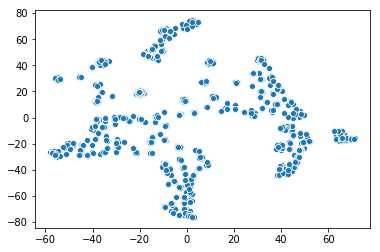

In [32]:
geo_data = dataset.vendor_geohash.unique().tolist() # get (x,y) cordiants for each geohash
geo_data = [process(item) for item in geo_data]
geo_data = np.asarray(geo_data)

tsne = TSNE()
geo_embedded = tsne.fit_transform(geo_data)

palette = sns.color_palette("bright", 10)
# sns.scatterplot(geo_embedded[:,0], geo_embedded[:,1], hue=y, legend='full', palette=palette)
sns.scatterplot(geo_embedded[:,0], geo_embedded[:,1], legend='full', palette=palette)

### [5] Visualize the distribution of vendors serving Vegetarian food across the city

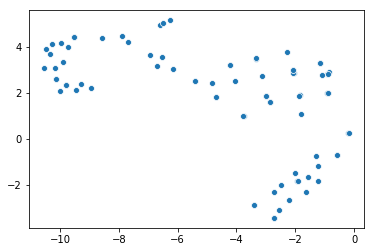

In [33]:
subset = dataset.loc[dataset['product_description'].isin(['Vegetarian', 'veg', 'vegetarian', 'vegan'])]

geo_data = subset.vendor_geohash.unique().tolist() # get (x,y) cordiants for each geohash
geo_data = [process(item) for item in geo_data]
geo_data = np.asarray(geo_data)

tsne = TSNE()
geo_embedded = tsne.fit_transform(geo_data)

palette = sns.color_palette("bright", 10)
# sns.scatterplot(geo_embedded[:,0], geo_embedded[:,1], hue=y, legend='full', palette=palette)
sns.scatterplot(geo_embedded[:,0], geo_embedded[:,1], legend='full', palette=palette)

### [6] Visualize the distribution of vendors serving non-veg food across the city

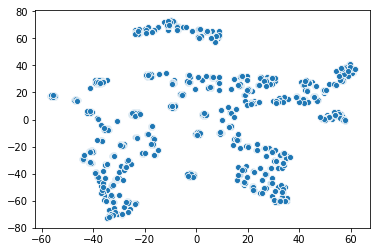

In [34]:
subset = dataset.loc[dataset['product_description'] != 'Vegetarian']

geo_data = subset.vendor_geohash.unique().tolist() # get (x,y) cordiants for each geohash
geo_data = [process(item) for item in geo_data]
geo_data = np.asarray(geo_data)

tsne = TSNE()
geo_embedded = tsne.fit_transform(geo_data)

palette = sns.color_palette("bright", 10)
# sns.scatterplot(geo_embedded[:,0], geo_embedded[:,1], hue=y, legend='full', palette=palette)
sns.scatterplot(geo_embedded[:,0], geo_embedded[:,1], legend='full', palette=palette)
ax.set(ylim=(10, 40))